# AE Experimentation

## Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from copy import deepcopy as dc

from utilities import split_data_into_sequences, train_test_split, Scaler
from data_evaluation.predictive.TimeSeriesDataset import TimeSeriesDataset
from VAE import FCVAE, train_vae

In [3]:
TEST_EXISTING_MODEL = False

In [4]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
GENERATE_NEW_SAMPLES = False

latent_size_1 = 32
latent_size_2 = 8

In [5]:
model_name = 'FCVAE'
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "num_epochs": 2000,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

## Data

In [6]:
traffic_df = pd.read_csv(REAL_DATA_FOLDER / "mitv_prep_1y.csv")
traffic_df.shape

(8759, 5)

In [7]:
traffic_np = traffic_df.to_numpy()
traffic_np.shape

(8759, 5)

### Preprocessing

In [8]:
# Train test split
train, test = train_test_split(traffic_np, split_ratio=0.8)
test, val = train_test_split(test, split_ratio=0.5)

In [9]:
# scale data
scaler = Scaler(train)
train_scaled = scaler.scale_data(train)
val_scaled = scaler.scale_data(val)
test_scaled = scaler.scale_data(test)

In [10]:
# split data into sequences
train_seq_scaled = split_data_into_sequences(train_scaled, hyperparameters['seq_len'], shuffle_data=False)
val_seq_scaled = split_data_into_sequences(val_scaled, hyperparameters['seq_len'], shuffle_data=False)
test_seq_scaled = split_data_into_sequences(test_scaled, hyperparameters['seq_len'], shuffle_data=False)

Shape of the data after splitting into sequences: (6996, 12, 5)
Shape of the data after splitting into sequences: (865, 12, 5)
Shape of the data after splitting into sequences: (865, 12, 5)


In [11]:
# create datasets
# NOTE: The targets are not used in the training process, but are required by the PyTorch Dataset class
train_dataset = TimeSeriesDataset(train_seq_scaled, np.zeros((train_seq_scaled.shape[0], 1)))
val_dataset = TimeSeriesDataset(val_seq_scaled, np.zeros((val_seq_scaled.shape[0], 1)))
test_dataset = TimeSeriesDataset(test_seq_scaled, np.zeros((test_seq_scaled.shape[0], 1)))

In [12]:
# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)

In [13]:
X_train, y = next(iter(train_loader))

In [14]:
X_train.shape

torch.Size([32, 12, 5])

## Autoencoder

In [15]:
model = FCVAE(latent_size_1=latent_size_1, latent_size_2=latent_size_2).to(hyperparameters['device'])


## Training

In [16]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=hyperparameters['lr'])
criterion = nn.MSELoss()

In [ ]:
if TEST_EXISTING_MODEL:
    model_path = f"{model_name}_best.pth"

else: 
    model_path = f"{model_name}_checkpoint.pth"
    
    train_losses, val_losses = train_vae(
        model=model,
        hyperparameters=hyperparameters,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        model_name=model_name
    )

In [33]:
if not TEST_EXISTING_MODEL:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

        # Diagramm 1 (oben links)
    axs[0].plot(train_losses, label="BCELoss")
    axs[0].set_title('Training Loss')

    axs[1].plot(val_losses, label="BCELoss")
    axs[1].set_title('Validation Loss')

In [34]:
# current best: Train 11: 0.0251, Val 11: 0.0218
if not TEST_EXISTING_MODEL:
    print(f"Train loss: {train_losses[-1]} | {train_losses[-11]}")
    print(f"Val loss: {val_losses[-1]} | {val_losses[-11]}")

In [35]:
# load best model
test_model = FCVAE(latent_size_1=latent_size_1, latent_size_2=latent_size_2).to(hyperparameters['device'])
test_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

torch.Size([4, 12, 5])


/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_21442/1748563461.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  random_test_sample = torch.tensor(samples[random_indices], dtype=torch.float32)


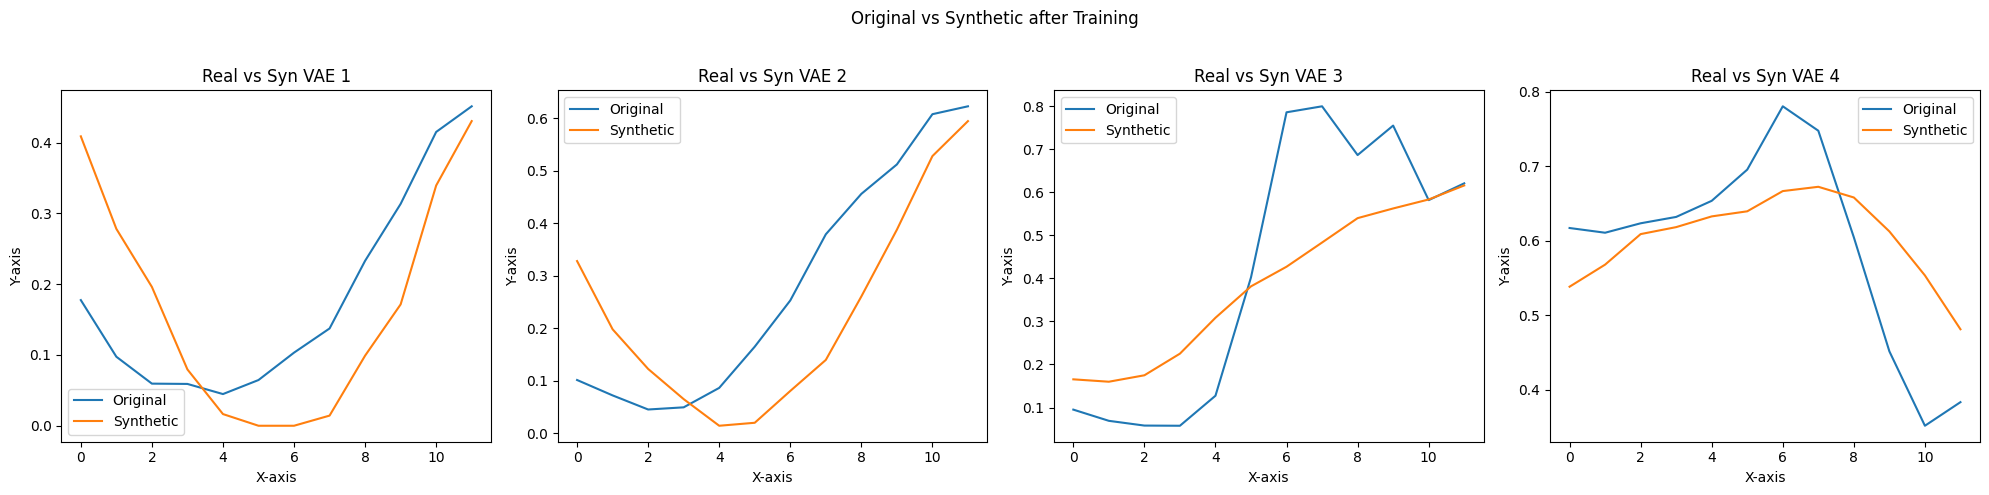

In [36]:
no_samples = 4
samples = next(iter(test_loader))[0]
random_indices = np.random.permutation(len(samples)-1)[:no_samples]
random_test_sample = torch.tensor(samples[random_indices], dtype=torch.float32)
random_test_sample = random_test_sample.float().to(hyperparameters['device'])

print(random_test_sample.shape)

test_model.eval()
with torch.inference_mode():
    _, _, test_pred = test_model(random_test_sample)
    # why is test_pred a tuple=

test_plot = dc(random_test_sample.detach().numpy())
pred_plot = dc(test_pred.detach().numpy())

# Erstellen Sie eine Figur und ein Array von Subplots
fig, axes = plt.subplots(1, no_samples, figsize=(20, 5))  # 1 Reihe, 5 Spalten

# Plotten Sie die Daten auf jedem Subplot
for mean in range(no_samples):
    axes[mean].plot(test_plot[mean, :, 0], label='Original')
    axes[mean].plot(pred_plot[mean, :, 0], label='Synthetic')
    axes[mean].legend()
    axes[mean].set_title(f'Real vs Syn VAE {mean+1}')
    axes[mean].set_xlabel('X-axis')
    axes[mean].set_ylabel('Y-axis')

# Setzen Sie einen Gesamt-Titel für die gesamte Figur
fig.suptitle('Original vs Synthetic after Training')

# Zeigen Sie die Plots an
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Platz für den Gesamt-Titel
plt.show()

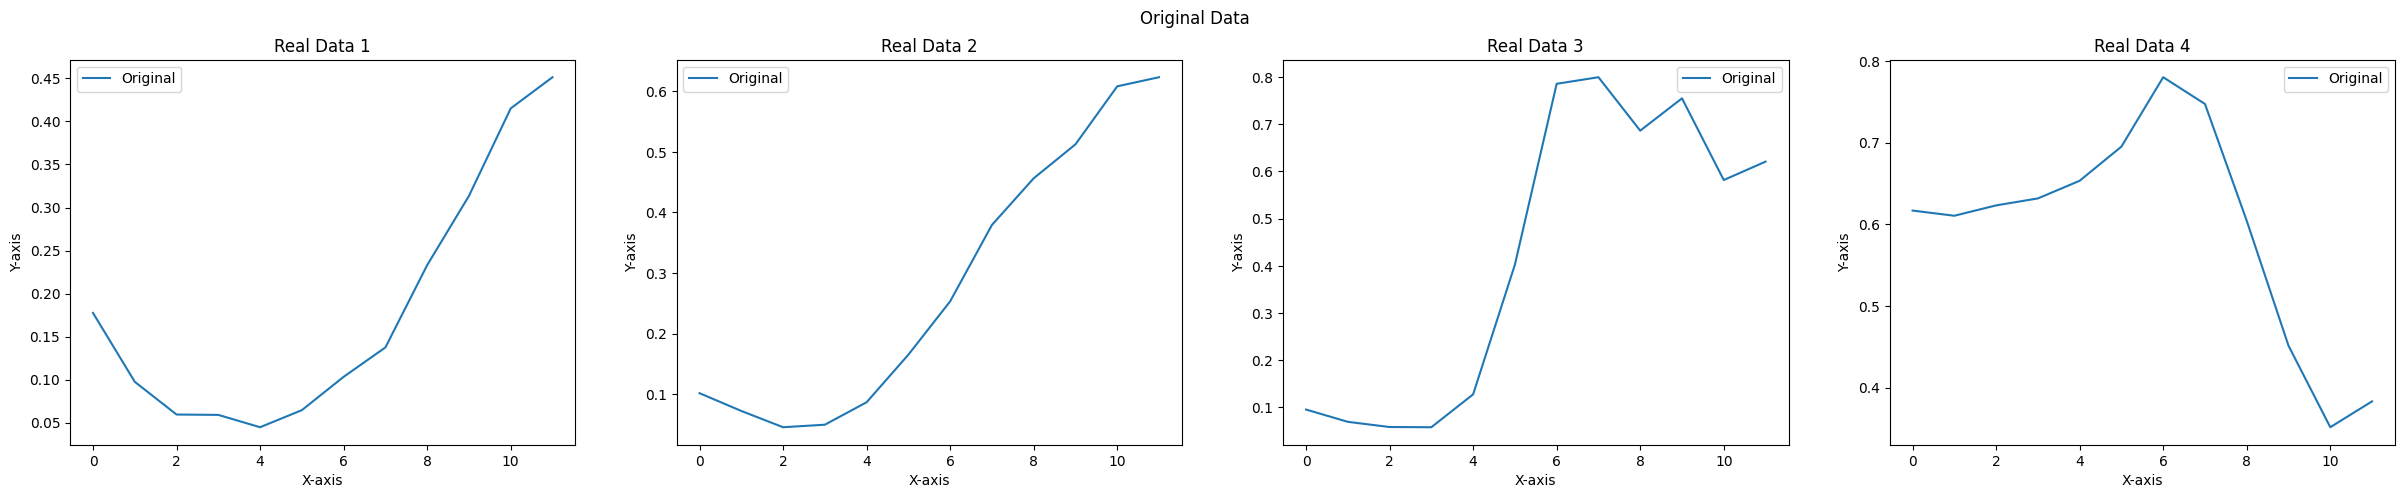

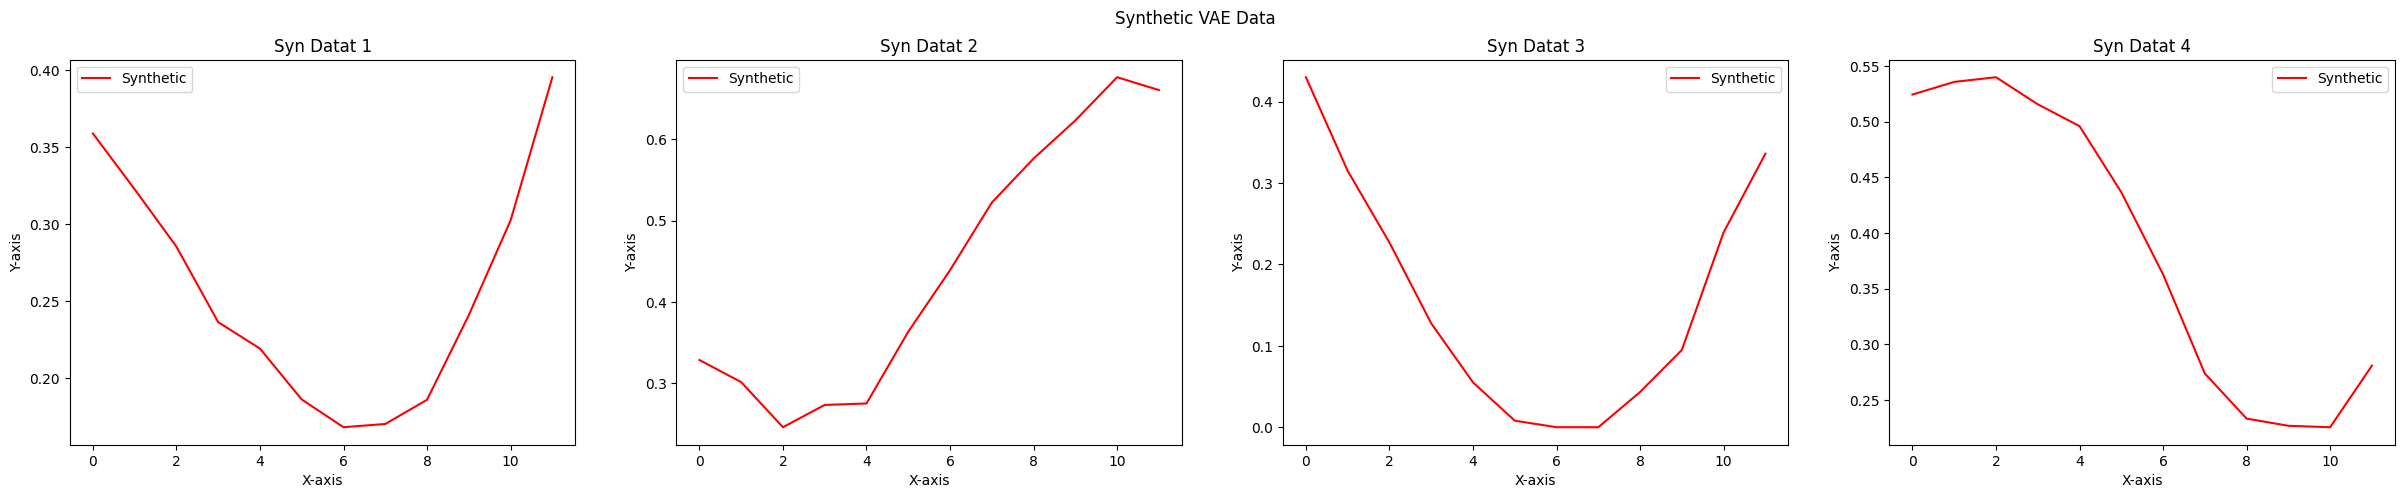

In [37]:
### get new data
z = torch.randn(no_samples, latent_size_2).to(hyperparameters['device'])
with torch.inference_mode():
    test_model.eval()
    new_samples = test_model.decode(z)


### Real Data Plot ###
fig, axes = plt.subplots(1, no_samples, figsize=(30, 5))  # 1 Reihe, 5 Spalten

for mean in range(no_samples):
    axes[mean].plot(test_plot[mean, :, 0], label='Original')
    axes[mean].legend()
    axes[mean].set_title(f'Real Data {mean+1}')
    axes[mean].set_xlabel('X-axis')
    axes[mean].set_ylabel('Y-axis')

fig.suptitle('Original Data')
plt.show()


### Synthetic data ###
fig, axes = plt.subplots(1, no_samples, figsize=(30, 5))  # 1 Reihe, 5 Spalten

for mean in range(no_samples):
    axes[mean].plot(new_samples[mean, :, 0], label='Synthetic', color='red')
    axes[mean].legend()
    axes[mean].set_title(f'Syn Datat {mean+1}')
    axes[mean].set_xlabel('X-axis')
    axes[mean].set_ylabel('Y-axis')

fig.suptitle('Synthetic VAE Data')
plt.show()

## Save Results

In [38]:
if GENERATE_NEW_SAMPLES:
    z = torch.randn(traffic_np.shape[0], latent_size_2).to(hyperparameters['device'])
    with torch.inference_mode():
        test_model.eval()
        new_samples = test_model.decode(z)

    print(f'Shape of new samples: {new_samples.shape}')

    new_samples_scaled = scaler.inverse_scale_complete_dataset(new_samples.detach().numpy(), True)
    no, seq_len, dim = new_samples_scaled.shape
    data_to_save = new_samples_scaled.reshape(-1, new_samples_scaled.shape[1]*new_samples_scaled.shape[2])
    np.savetxt(f'vae_{no}_{seq_len}_{dim}.csv', data_to_save, delimiter=',')